In [ ]:
# CSV 파일 불러오기
# for vs code
file_path1 = 'data/Meteorological_2019_01.csv'
file_path2 = 'data/서울시_대기질_2019_01.csv'
xtest_path = 'data/Meteorological_2020_01.csv'
ytest_path = 'data/서울시_대기질_2020_01.csv'

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# %pip install scikeras

In [3]:
# CSV 파일 불러오기
# for google colab
file_path1 = '/content/drive/MyDrive/2024-2학기_연구참여/data/Meteorological_2019_01.csv'
file_path2 = '/content/drive/MyDrive/2024-2학기_연구참여/data/서울시_대기질_2019_01.csv'
xtest_path = '/content/drive/MyDrive/2024-2학기_연구참여/data/Meteorological_2020_01.csv'
ytest_path = '/content/drive/MyDrive/2024-2학기_연구참여/data/서울시_대기질_2020_01.csv'

In [4]:
# User defined file import
import numpy as np
import pandas as pd
import sys
sys.path.append('/content/drive/MyDrive/2024-2학기_연구참여/module')

from pre_process import (
    read_processing, time_processing, interpol_processing,
    scaling, log_scaling, boxcox_scaling, standard_scaling, quantile_scaling,
    latlon_to_grid, map_processing, create_mask, filtering_data
)

from visualization import (
    plot_subplots, plot_ozone_maps
)

from model import (
    OzoneModel,train_model, evaluate_model,
    predict, maskedHuber, convertLoader,
    TrainML, PredictML, EvaluateML
)

In [5]:
# 서울시의 위도와 경도 범위 설정
seoul_lat_min, seoul_lat_max = 37.4133, 37.7151  # 남북 경계 위도
seoul_lon_min, seoul_lon_max = 126.7341, 127.2693  # 동서 경계 경도

# 'Meteorological data' 측정 지역의 위도와 경도 정보
met_regions_data = {
    'region': ['강남', '서초', '강동', '송파', '강서', '양천', '도봉', '노원', '동대문', '중랑', '기상청', '마포', '서대문', '광진',
               '성북', '용산', '은평', '금천', '한강', '중구', '성동', '구로', '강북*', '남현', '관악', '영등포', '현충원'],
    'latitude': [37.49794, 37.47650, 37.53010, 37.51456, 37.55095, 37.51656, 37.66877, 37.65526, 37.57491, 37.59508, 37.56556,
                 37.56632, 37.57655, 37.53865, 37.58968, 37.53110, 37.60277, 37.45686, 37.52770, 37.56382, 37.56351, 37.49543,
                 37.646995, 37.46769, 37.47808, 37.52667, 37.50001],
    'longitude': [127.02761, 127.03250, 127.12587, 127.10662, 126.84953, 126.86658, 127.04744, 127.07712, 127.03963, 127.09368, 126.96691,
                  126.90131, 126.93784, 127.08237, 127.01667, 126.97960, 126.93040, 126.89576, 126.99818, 126.99760, 127.03722, 126.88740,
                  127.01371, 126.95818, 126.95143, 126.89636, 126.97422]
}

# DataFrame 생성
met_regions_df = pd.DataFrame(met_regions_data)
# row, col 행 추가
met_regions_df[['row', 'col']] = met_regions_df.apply(
    lambda r: pd.Series(
        latlon_to_grid(r['latitude'], r['longitude'], seoul_lat_min, seoul_lat_max, seoul_lon_min, seoul_lon_max)
        ),axis = 1
        )

# '서울시 대기질 데이터' 각 구의 위도와 경도 정보
air_regions_data = {
    'region': ['종로구', '용산구', '중구', '은평구', '서대문구', '마포구', '광진구', '노원구', '중랑구', '도봉구',
               '성북구', '성동구', '강북구', '동대문구', '동작구', '영등포구', '강서구', '관악구', '양천구', '구로구',
               '금천구', '강남구', '서초구', '강동구', '송파구'],
    'latitude': [37.573050, 37.531100, 37.563820, 37.602770, 37.576550, 37.566320, 37.538650, 37.655260, 37.595080, 37.668770,
                 37.589680, 37.563510, 37.646995, 37.574910, 37.512410, 37.526670, 37.550950, 37.478080, 37.516560, 37.495430,
                 37.456860, 37.497940, 37.476500, 37.530100, 37.514560],
    'longitude': [126.979340, 126.979600, 126.997600, 126.930400, 126.937840, 126.901310, 127.082370, 127.077120, 127.093680, 127.047440,
                  127.016670, 127.037220, 127.013710, 127.039630, 126.941040, 126.896360, 126.849530, 126.951430, 126.866580, 126.887400,
                  126.895760, 127.027610, 127.032500, 127.125870, 127.106620]
}

# DataFrame 생성
air_regions_df = pd.DataFrame(air_regions_data)
# row, col 행 추가
air_regions_df[['row', 'col']] = air_regions_df.apply(
    lambda r: pd.Series(
        latlon_to_grid(r['latitude'], r['longitude'], seoul_lat_min, seoul_lat_max, seoul_lon_min, seoul_lon_max)
        ),axis = 1
        )

In [6]:
# 변수 초기화
time_size = 3
grid_size = 32
feature_cols = ['기온(°C)']
n_features = len(feature_cols)
grid_data = np.zeros((744, time_size, grid_size, grid_size, n_features+1))
label_grid_data = np.zeros((744, 1, grid_size, grid_size, 1))
time_stamp = np.empty(744, dtype='datetime64[m]')

# Data PreProcessing
met_data, air_quality_data = read_processing(file_path1, file_path2)
time_processing(met_data, air_quality_data)
met_data = interpol_processing(met_data, feature_cols)
#scaling
x_train_scaler = scaling(met_data, feature_cols) # scaling
y_qt_scaler = quantile_scaling(air_quality_data, ['오존(ppm)'])
y_train_scaler = scaling(air_quality_data, ['오존(ppm)']) # scaling

# mapping
map_processing(met_data, air_quality_data, grid_data, label_grid_data, time_stamp,
               feature_cols, met_regions_df, air_regions_df)
label_grid_data = label_grid_data.reshape(label_grid_data.shape[0],-1)

2019-01-01 00:00:00 2019-01-31 23:00:00


In [7]:
# loading test_data
te_grid_data = np.zeros((744, time_size, grid_size, grid_size, n_features+1))
te_label_grid_data = np.zeros((744, 1, grid_size, grid_size, 1))
te_time_stamp = np.empty(744, dtype='datetime64[m]')

# Data PreProcessing
te_met_data, te_air_quality_data = read_processing(xtest_path, ytest_path)
time_processing(te_met_data, te_air_quality_data)
te_met_data = interpol_processing(df=te_met_data, cols=feature_cols)
te_met_data[feature_cols] = x_train_scaler.transform(te_met_data[feature_cols]) # scaling
te_air_quality_data[['오존(ppm)']] = y_qt_scaler.transform(te_air_quality_data[['오존(ppm)']])
te_air_quality_data[['오존(ppm)']] = y_train_scaler.transform(te_air_quality_data[['오존(ppm)']]) # scaling

# Mapping
map_processing(te_met_data, te_air_quality_data, te_grid_data, te_label_grid_data, te_time_stamp, feature_cols, met_regions_df, air_regions_df)

# save test_data
xtest = te_grid_data
ytest = te_label_grid_data.reshape(te_label_grid_data.shape[0], -1)

2020-01-01 00:00:00 2020-01-31 23:00:00


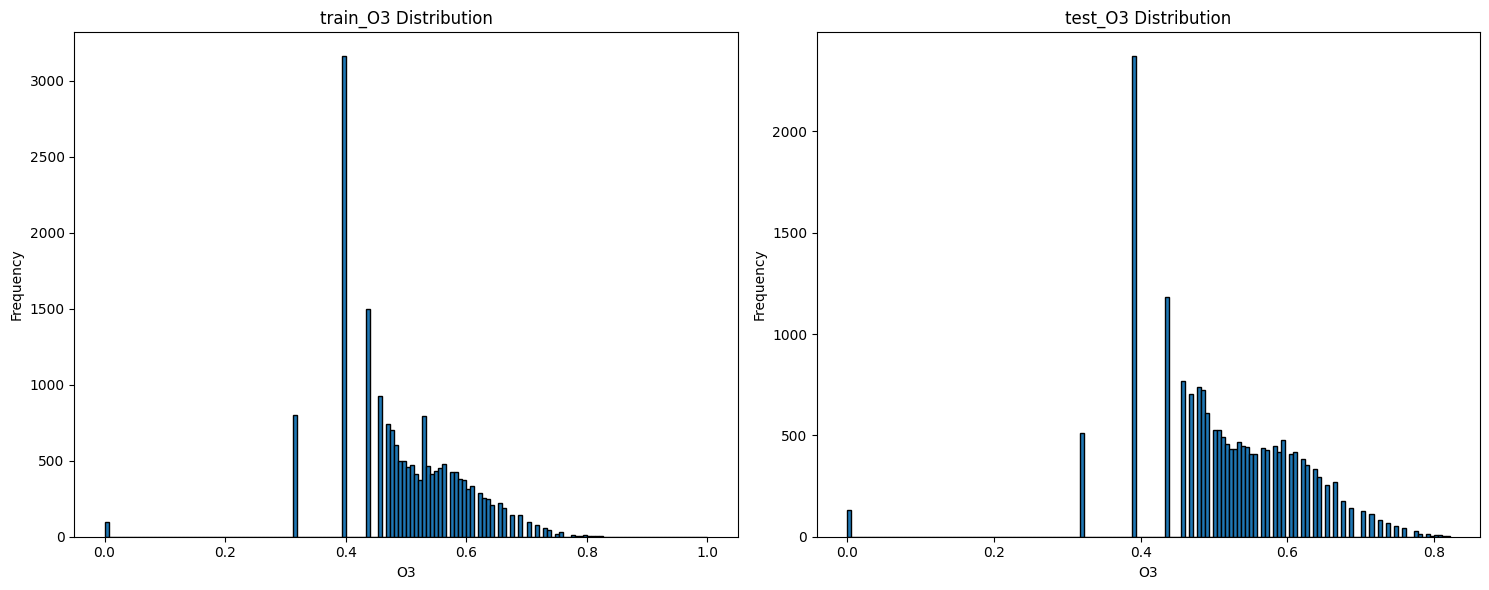

In [8]:
# 데이터 사양 정의
data_specs = [
    {
        'plot_type': 'hist',  # 히스토그램
        'data_list': [air_quality_data['오존(ppm)']],  # 첫 번째 데이터
        'bins': 150,  # 빈 수
        'alpha_list': [1.0],  # 투명도 (1.0은 불투명)
        'xlabel': 'O3',  # x축 레이블
        'ylabel': 'Frequency',  # y축 레이블
        'title': 'train_O3 Distribution',  # 서브플롯 제목
        'grid': False  # 그리드 없음
    },
    {
        'plot_type': 'hist',  # 히스토그램
        'data_list': [te_air_quality_data['오존(ppm)']],  # 두 번째 데이터
        'bins': 150,  # 빈 수
        'alpha_list': [1.0],  # 투명도 (1.0은 불투명)
        'xlabel': 'O3',  # x축 레이블
        'ylabel': 'Frequency',  # y축 레이블
        'title': 'test_O3 Distribution',  # 서브플롯 제목
        'grid': False  # 그리드 없음
    }
]

# 함수 호출하여 그래프 그리기
plot_subplots(data_specs, figsize=(15, 6))

In [9]:
# bit_mask 제작
bit_mask = create_mask(air_regions_df)

In [10]:
# 1) 모델 학습
model_list = TrainML(grid_data, label_grid_data, bit_mask, n_features)

Epoch 1/300 | Train HuberLoss: 0.0357 | Train MAE: 0.0052 | Val HuberLoss: 0.0030| Val MAE: 0.0014
Epoch 2/300 | Train HuberLoss: 0.0048 | Train MAE: 0.0019 | Val HuberLoss: 0.0025| Val MAE: 0.0013
Epoch 3/300 | Train HuberLoss: 0.0041 | Train MAE: 0.0017 | Val HuberLoss: 0.0024| Val MAE: 0.0012
Epoch 4/300 | Train HuberLoss: 0.0039 | Train MAE: 0.0016 | Val HuberLoss: 0.0022| Val MAE: 0.0012
Epoch 5/300 | Train HuberLoss: 0.0036 | Train MAE: 0.0016 | Val HuberLoss: 0.0022| Val MAE: 0.0012
Epoch 6/300 | Train HuberLoss: 0.0034 | Train MAE: 0.0015 | Val HuberLoss: 0.0021| Val MAE: 0.0011
Epoch 7/300 | Train HuberLoss: 0.0032 | Train MAE: 0.0015 | Val HuberLoss: 0.0020| Val MAE: 0.0011
Epoch 8/300 | Train HuberLoss: 0.0030 | Train MAE: 0.0014 | Val HuberLoss: 0.0019| Val MAE: 0.0011
Epoch 9/300 | Train HuberLoss: 0.0028 | Train MAE: 0.0013 | Val HuberLoss: 0.0019| Val MAE: 0.0011
Epoch 10/300 | Train HuberLoss: 0.0026 | Train MAE: 0.0013 | Val HuberLoss: 0.0018| Val MAE: 0.0010
Epoch 11/

In [11]:
#2) 예측
xtrain = grid_data
ytrain = label_grid_data
train_pred = PredictML(model_list, xtrain)
test_pred = PredictML(model_list, xtest)
test_pred_all = PredictML(model_list, xtest, onlyStation=False)

In [12]:
# 3) 평가
EvaluateML(model_list, xtest, ytest)

Model1 Prediction: 
Test HuberLoss: 0.0032, Test MAE: 0.0014
Model2 Prediction: 
Test HuberLoss: 0.0027, Test MAE: 0.0012
Model3 Prediction: 
Test HuberLoss: 0.0020, Test MAE: 0.0010
Model4 Prediction: 
Test HuberLoss: 0.0018, Test MAE: 0.0009
Model5 Prediction: 
Test HuberLoss: 0.0018, Test MAE: 0.0010
Mean Test MAE --> 0.0011


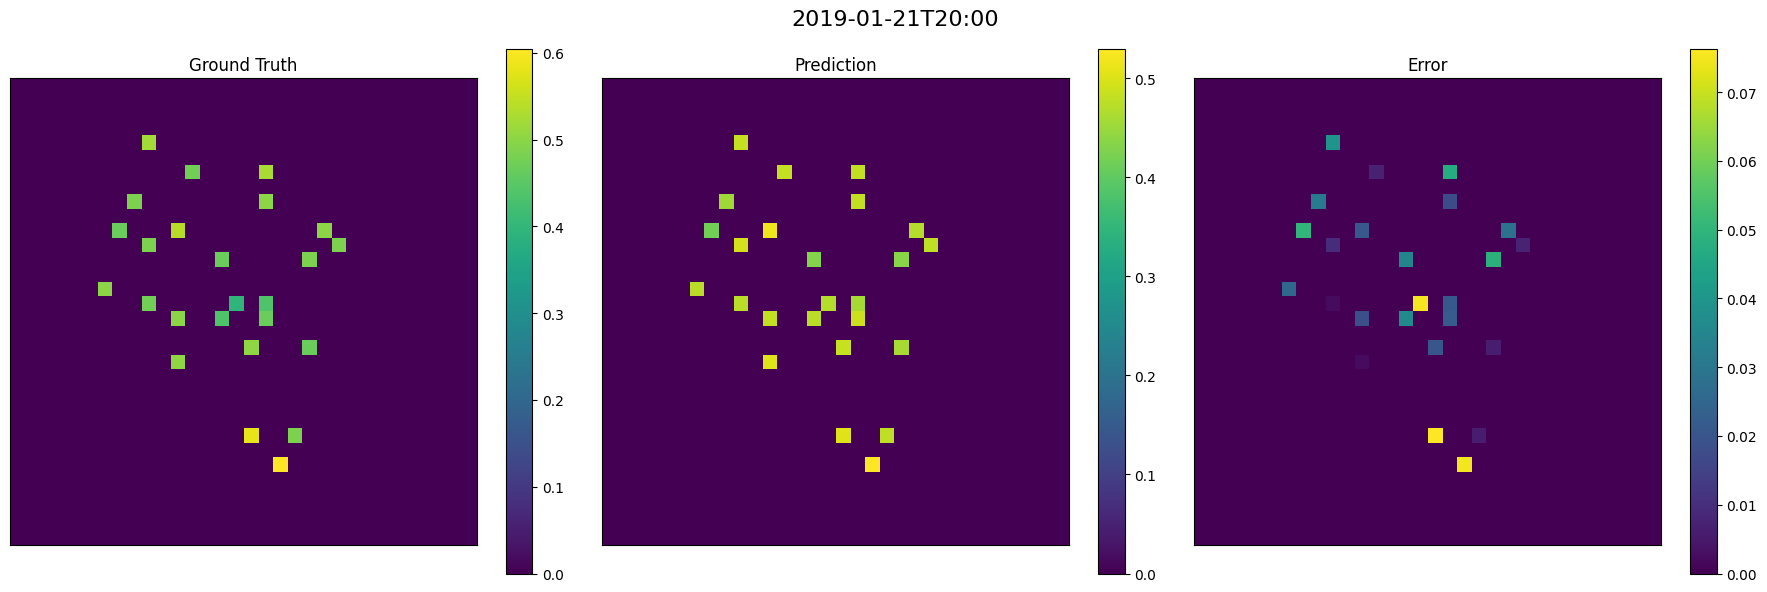

In [13]:
# train prediction 시각화
plot_ozone_maps(index=500, g_data=ytrain, prediction = train_pred, time_stamp = time_stamp) #추후 train의 timestamp가 필요하다.

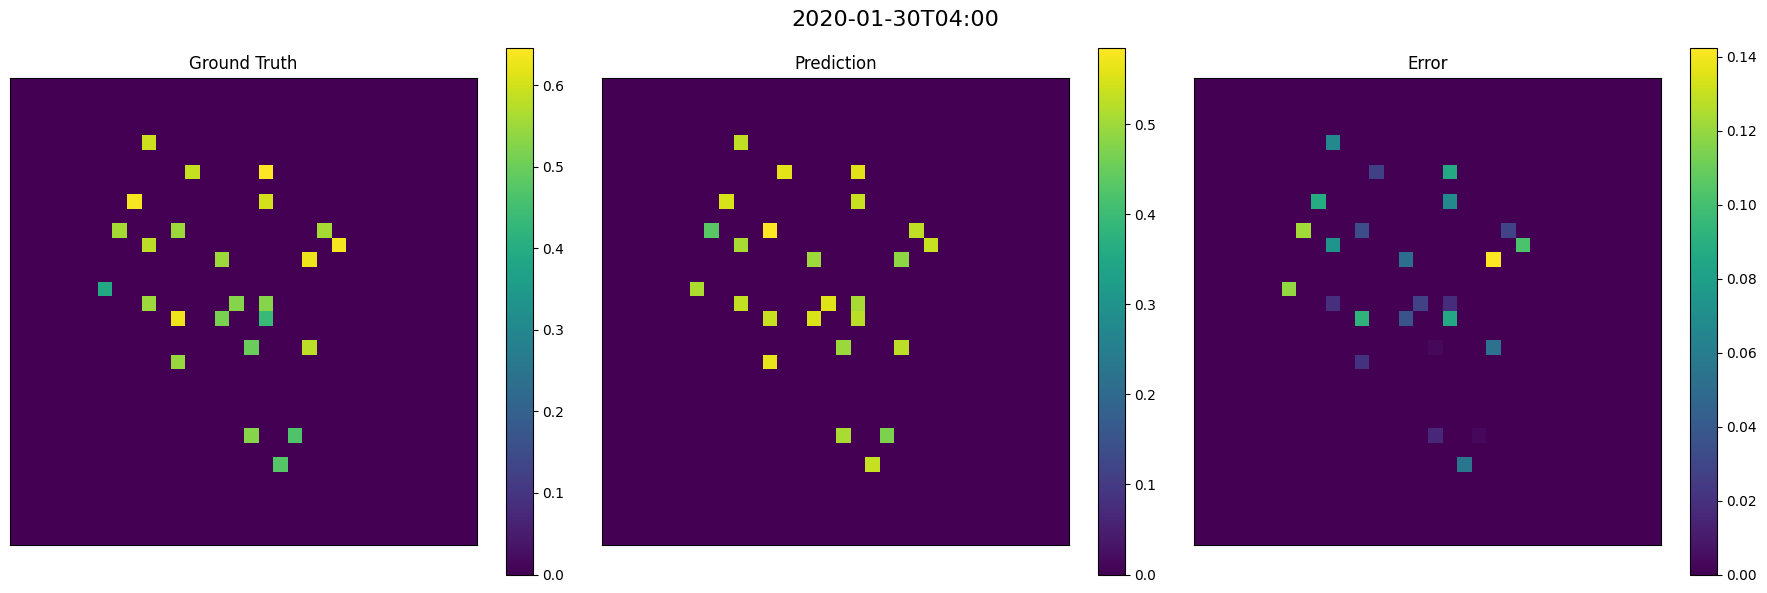

In [14]:
# test prediction 시각화
plot_ozone_maps(index=700, g_data=ytest, prediction=test_pred, time_stamp = te_time_stamp)

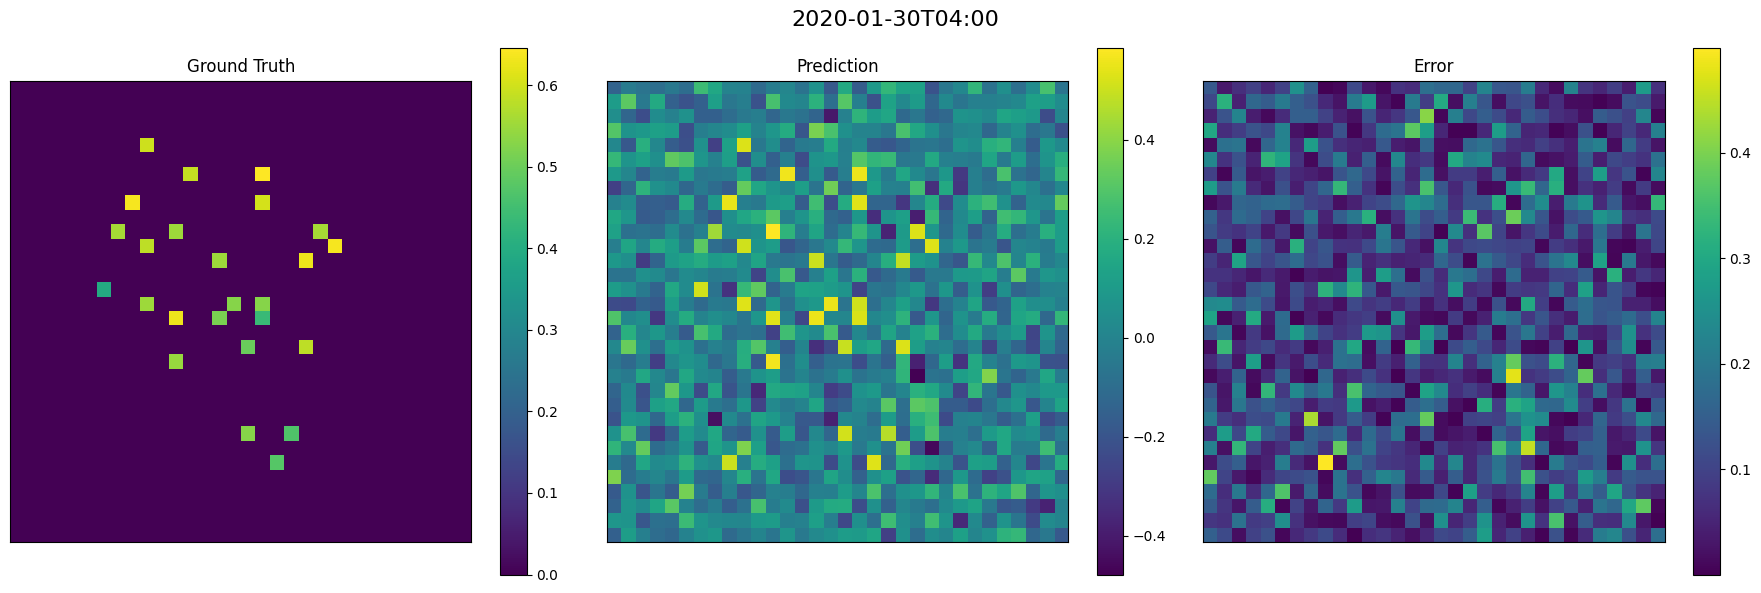

In [15]:
# test prediction 시각화 (not only station)
plot_ozone_maps(index=700, g_data=ytest, prediction=test_pred_all, time_stamp = te_time_stamp)

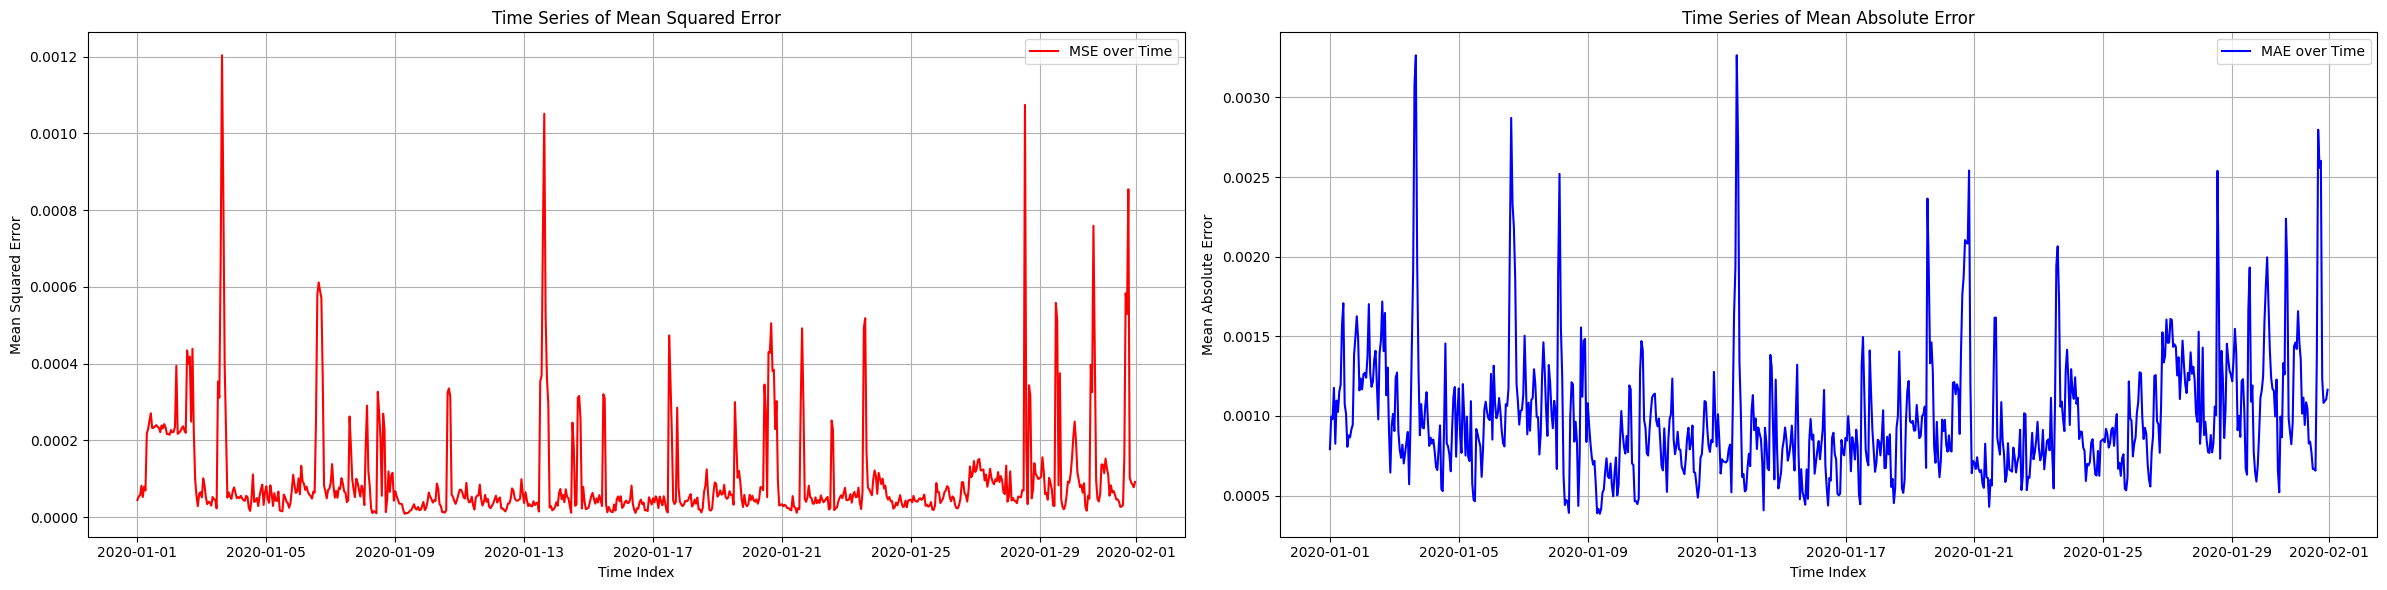

In [16]:
# 데이터 준비
gt = ytest.reshape(-1, grid_size, grid_size)
pdc = test_pred
pdc = pdc.reshape(-1,32,32)
mse_per_time = np.mean((gt - pdc) ** 2, axis=(1, 2))   # 시간별 MSE 계산 (num_samples,)
mae_per_time = np.mean(np.abs(gt - pdc), axis=(1, 2))  # 시간별 MAE 계산 (num_samples,)

data_specs = [
    {
        'plot_type': 'line',  # 라인 플롯
        'x': te_time_stamp,   # x축 데이터 (시간 인덱스)
        'y_list': [mse_per_time],  # y축 데이터 (MSE)
        'labels': ['MSE over Time'],  # 레이블 (legend에 표시될 텍스트)
        'colors': ['red'],  # 선 색상
        'xlabel': 'Time Index',  # x축 레이블
        'ylabel': 'Mean Squared Error',  # y축 레이블
        'title': 'Time Series of Mean Squared Error',  # 서브플롯 제목
        'grid': True  # 그리드 표시
    },
    {
        'plot_type': 'line',  # 라인 플롯
        'x': te_time_stamp,   # x축 데이터 (시간 인덱스)
        'y_list': [mae_per_time],  # y축 데이터 (MAE)
        'labels': ['MAE over Time'],  # 레이블 (legend에 표시될 텍스트)
        'colors': ['blue'],  # 선 색상
        'xlabel': 'Time Index',  # x축 레이블
        'ylabel': 'Mean Absolute Error',  # y축 레이블
        'title': 'Time Series of Mean Absolute Error',  # 서브플롯 제목
        'grid': True  # 그리드 표시
    }
]

# 그래프 그리기
plot_subplots(data_specs, figsize=(24, 6))


In [20]:
regions = air_regions_df['region'].unique()

for region in regions:
  y_coord = air_regions_df.loc[air_regions_df['region']==region, 'row'].values[0]
  x_coord = air_regions_df.loc[air_regions_df['region']==region, 'col'].values[0]

  # 시간에 따른 특정 위치의 오존 농도 추출
  gt_at_location = gt[:, y_coord, x_coord]  # (num_samples,)
  pred_at_location = pdc[:, y_coord, x_coord]  # (num_samples,)

  # data_specs 정의 (라인 플롯)
  data_specs = [
      {
          'plot_type': 'line',  # 라인 플롯
          'x': te_time_stamp,   # x축 데이터 (시간 인덱스)
          'y_list': [gt_at_location, pred_at_location],  # y축 데이터 (Ground Truth & Prediction)
          'labels': ['Ground Truth at Location', 'Prediction at Location'],  # 레이블
          'colors': ['blue', 'red'],  # 선 색상
          'xlabel': 'Time Index',  # x축 레이블
          'ylabel': 'Ozone Concentration',  # y축 레이블
          'title': f'Time Series of Ozone Concentration at Location ({x_coord}, {y_coord})',  # 서브플롯 제목
          'grid': True  # 그리드 표시
      }
  ]

  # 그래프 그리기
  plot_subplots(data_specs, figsize=(12, 6))


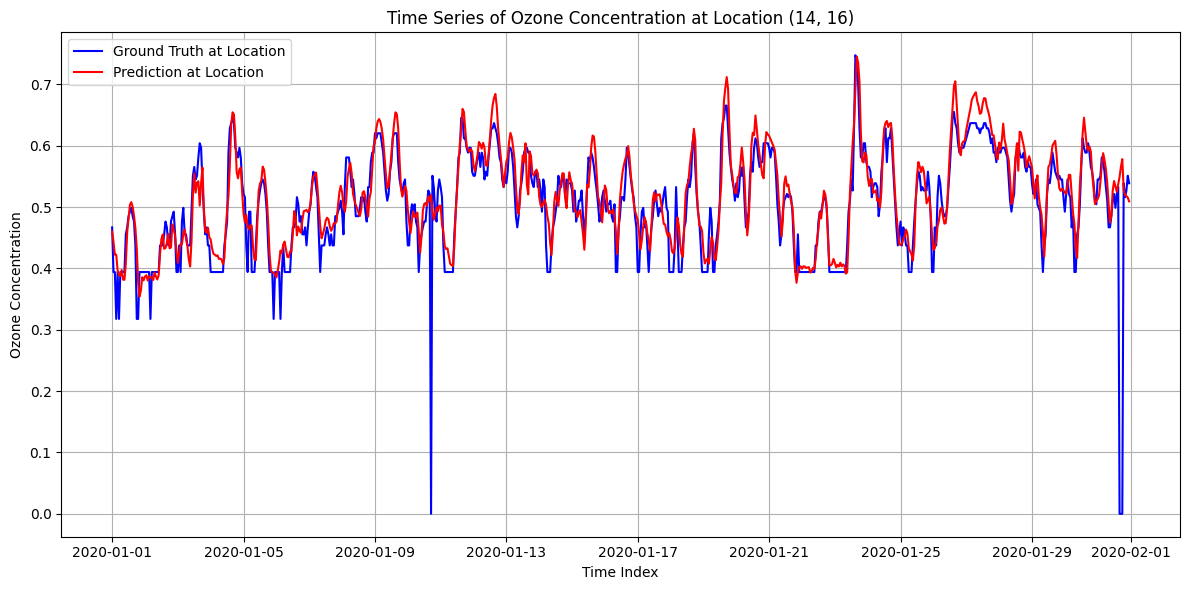

In [17]:
# 한 지역을 고정하고 시간에 따른 분포 관찰
x_coord = 14  # 가로 위치 (0부터 31까지)
y_coord = 16 # 세로 위치 (0부터 31까지)

# 시간에 따른 특정 위치의 오존 농도 추출
gt_at_location = gt[:, y_coord, x_coord]  # (num_samples,)
pred_at_location = pdc[:, y_coord, x_coord]  # (num_samples,)

# data_specs 정의 (라인 플롯)
data_specs = [
    {
        'plot_type': 'line',  # 라인 플롯
        'x': te_time_stamp,   # x축 데이터 (시간 인덱스)
        'y_list': [gt_at_location, pred_at_location],  # y축 데이터 (Ground Truth & Prediction)
        'labels': ['Ground Truth at Location', 'Prediction at Location'],  # 레이블
        'colors': ['blue', 'red'],  # 선 색상
        'xlabel': 'Time Index',  # x축 레이블
        'ylabel': 'Ozone Concentration',  # y축 레이블
        'title': f'Time Series of Ozone Concentration at Location ({x_coord}, {y_coord})',  # 서브플롯 제목
        'grid': True  # 그리드 표시
    }
]

# 그래프 그리기
plot_subplots(data_specs, figsize=(12, 6))

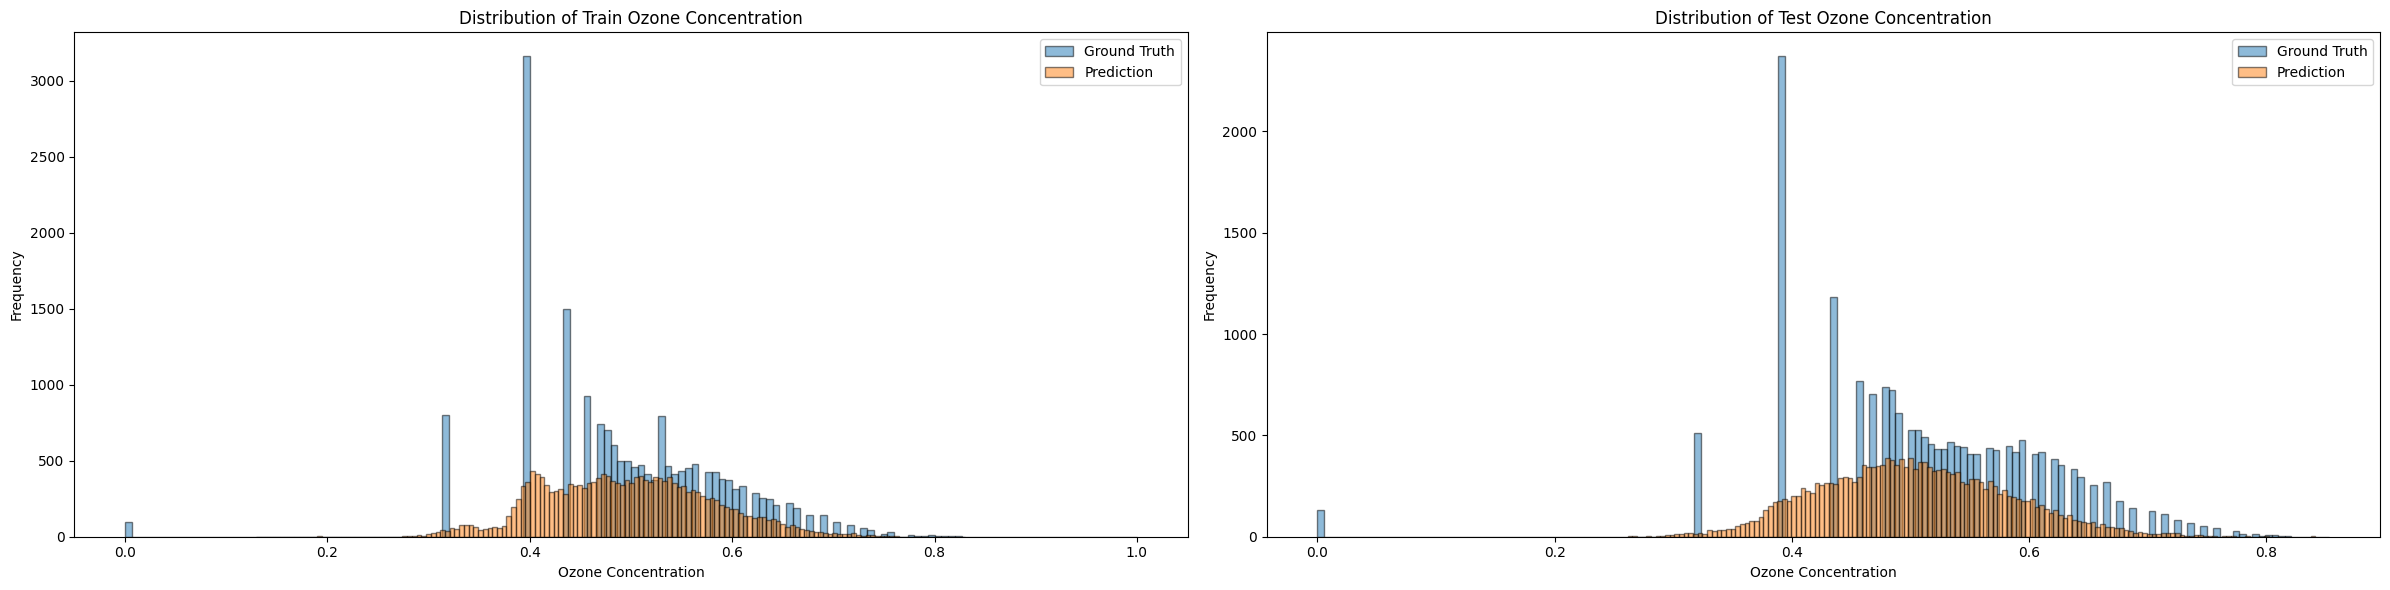

In [ ]:
# 전체 시간의 오존 값의 분포 비교 (관측소가 있는 지점만)
# mask, prediction
mask = model_list[0].mask

# mask가 CUDA 텐서인 경우 CPU로 이동
if mask.is_cuda:
    mask = mask.cpu()

# data filtering
gt_train_flat, pred_train_flat = filtering_data(ytrain, train_pred, mask)
gt_test_flat, pred_test_flat = filtering_data(ytest, test_pred, mask)

# data_specs 정의 (히스토그램)
data_specs = [
    {
        'plot_type': 'hist',  # 히스토그램
        'data_list': [gt_train_flat, pred_train_flat],  # 두 개의 데이터
        'bins': 150,  # 빈 수
        'alpha_list': [0.5, 0.5],  # 투명도
        'labels': ['Ground Truth', 'Prediction'],  # 레이블
        'xlabel': 'Ozone Concentration',  # x축 레이블
        'ylabel': 'Frequency',  # y축 레이블
        'title': 'Distribution of Train Ozone Concentration',  # 서브플롯 제목
        'grid': False  # 그리드 표시 여부
    },
    {
        'plot_type': 'hist',  # 히스토그램
        'data_list': [gt_test_flat, pred_test_flat],  # 두 개의 데이터
        'bins': 150,  # 빈 수
        'alpha_list': [0.5, 0.5],  # 투명도
        'labels': ['Ground Truth', 'Prediction'],  # 레이블
        'xlabel': 'Ozone Concentration',  # x축 레이블
        'ylabel': 'Frequency',  # y축 레이블
        'title': 'Distribution of Test Ozone Concentration',  # 서브플롯 제목
        'grid': False  # 그리드 표시 여부
    }
]

# 그래프 그리기
plot_subplots(data_specs, figsize=(24, 6))